In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon


import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
from descartes import PolygonPatch

from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)

## Create Network Graphs

In [2]:
# Place you are interested
place = "Stockholm, Sweden"

# Transportation mode
mode = "walk"

# Create network graph from place and mode
G = ox.graph_from_address(place, distance=1500, simplify=True, network_type=mode)

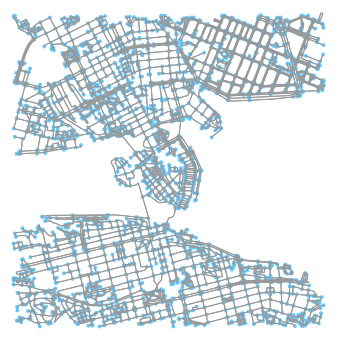

<Figure size 432x288 with 0 Axes>

In [3]:
fig, ax = ox.plot_graph(G, save=True);
plt.tight_layout()
#plt.savefig("graph.png")
plt.show()

In [4]:
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'stockholm.html'
graph_map.save(filepath)
IFrame(filepath, width=900, height=500)

In [5]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    # Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, distance=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, distance=dist, network_type=transport_mode )
    return G

In [6]:
coordinates = create_graph((51.500734, -0.124518), 1500, "drive", loc_type="points")

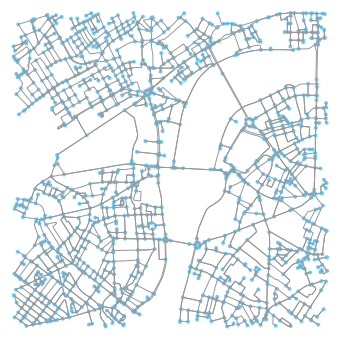

<Figure size 432x288 with 0 Axes>

In [7]:
fig, ax = ox.plot_graph(coordinates);
plt.tight_layout()
plt.show()

In [8]:
graph_map = ox.plot_graph_folium(coordinates, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'coordinates.html'
graph_map.save(filepath)
IFrame(filepath, width=900, height=500)

## Create Isochrones from Network Graphs

In [5]:

# Create a graph
G = create_graph(loc= "Stockholm, Sweden", 
                 dist= 5000, 
                 transport_mode= "walk", 
                 )


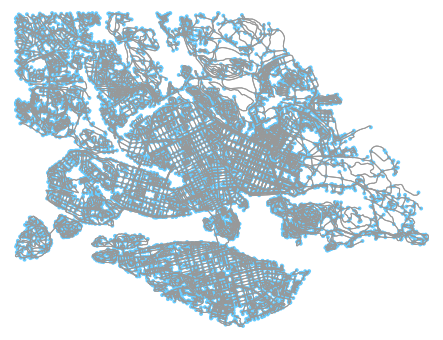

<Figure size 432x288 with 0 Axes>

In [6]:
fig, ax = ox.plot_graph(G);
plt.tight_layout()
plt.show()

In [7]:
# Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

# Specify where you want to start and get nearest nodes. 
point_of_interest = ox.get_nearest_node(G, point=(59.325273, 18.070998))

# Project a graph from lat-long to the UTM zone appropriate for its geographic location.
G = ox.project_graph(G)


In [8]:
# Trip time in Mintues
trip_times = [5, 15, 25, 40, 60]

# walking speed in km/hour
travel_speed = 4.5

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

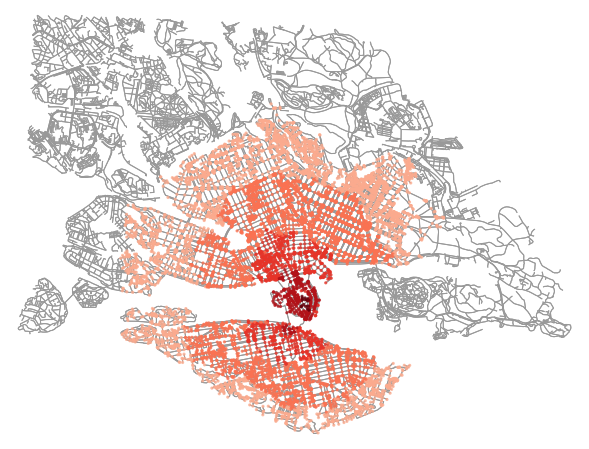

In [13]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, save=True, node_alpha=0.8, node_zorder=2)

In [11]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

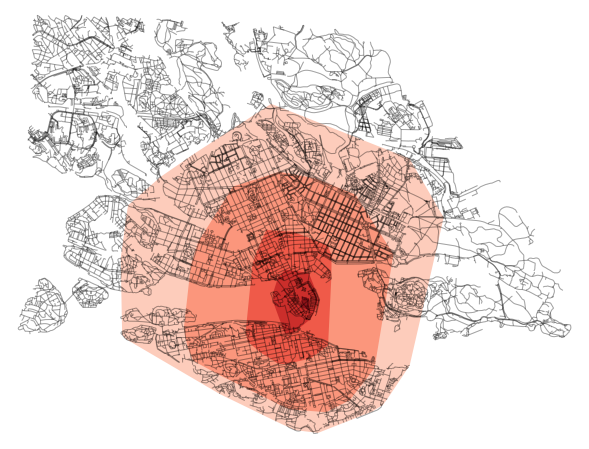

In [14]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, save=True, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

#### Export to Isochrone polygons 

In [19]:
gdf = gpd.GeoDataFrame({"time": trip_times}, geometry= isochrone_polys)
gdf.head()


,time,geometry
0,5,"POLYGON ((334043.046646532 6576147.425609123, ..."
1,15,"POLYGON ((333825.5993673931 6577676.296871154,..."
2,25,"POLYGON ((333454.1426663193 6578552.432587424,..."
3,40,"POLYGON ((333181.2697461867 6579254.232614744,..."
4,60,"POLYGON ((333119.4051163771 6579827.436386704,..."


In [20]:
gdf_edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
gdf_edges.head()

,u,v,key,osmid,name,maxspeed,highway,oneway,length,geometry,time,lanes,ref,bridge,access,junction,tunnel,width
0,1891237892,32915758,0,"[325900272, 325898704, 325900275, 24323731, 56...",Karlbergs Strand,30,unclassified,False,493.360,LINESTRING (329398.6243575014 6582180.77522123...,6.578133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,365985796,365986289,0,32544787,Primusgatan,30,residential,True,104.932,LINESTRING (329577.5654497431 6579822.64174189...,1.399093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,365985796,446295099,0,37999717,NaN,NaN,living_street,False,40.153,LINESTRING (329577.5654497431 6579822.64174189...,0.535373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,365985797,446295190,0,32544783,Primusgatan,30,residential,False,61.425,LINESTRING (329577.5389835712 6579833.32544966...,0.819000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,365985797,365985796,0,32544787,Primusgatan,30,residential,True,10.874,LINESTRING (329577.5389835712 6579833.32544966...,0.144987,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
gdf_edges.crs, gdf_nodes.crs

('+proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
 '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

In [22]:
gdf = gpd.GeoDataFrame({"time": trip_times}, geometry= isochrone_polys)
gdf.head()

,time,geometry
0,5,"POLYGON ((334043.046646532 6576147.425609123, ..."
1,15,"POLYGON ((333825.5993673931 6577676.296871154,..."
2,25,"POLYGON ((333454.1426663193 6578552.432587424,..."
3,40,"POLYGON ((333181.2697461867 6579254.232614744,..."
4,60,"POLYGON ((333119.4051163771 6579827.436386704,..."


In [23]:
gdf.crs = gdf_edges.crs
gdf.to_file("isopolys_z34.shp")

In [24]:
gdf.crs

'+proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

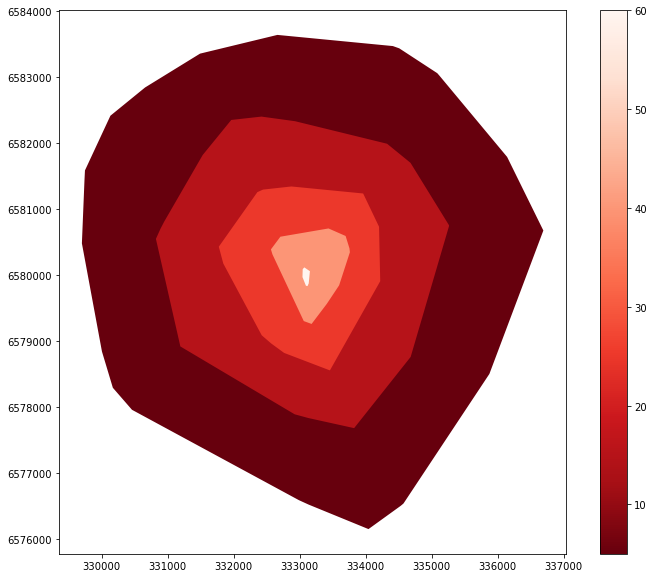

In [35]:
fig, ax = plt.subplots(figsize=(12,10))
gdf.plot(column="time", ax=ax, cmap="Reds_r", legend=True);